In [9]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time

In [10]:
def draw(X, y):
    if X.shape[-1] >= 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['class'] = y
        plt.figure(figsize=(6, 5))
        sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='class', 
                        palette=sns.color_palette("husl", len(np.unique(y))),  legend="full")
    elif X.shape[-1] == 1:
        padding = np.random.random(X.shape)
        X = np.concatenate([X, padding], axis=-1)
        draw(X, y)
    else: # dim == 0
        raise RuntimeError("X.shape[-1]==0, Make sure a right X input.")
    
class Timer:
    def __init__(self, msg):
        self.msg = msg
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, exc_type, exc_value, traceback):
        self.end = time.time()
        self.interval = self.end - self.start
        print(f"{self.msg}: {self.interval * 1000:.2f}ms")

---
### load sonar

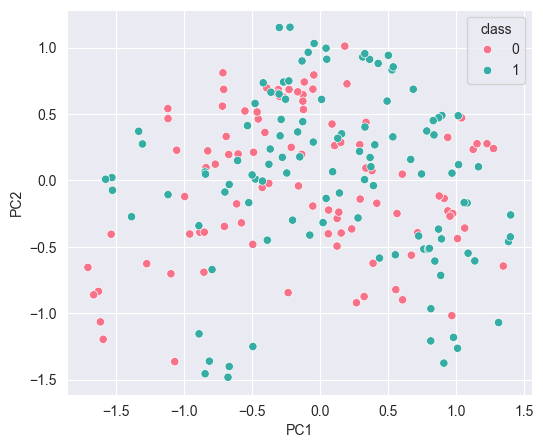

In [11]:
from sklearn.preprocessing import StandardScaler
sonar = pd.read_csv("./sonar.all-data.csv", header=None)
X = sonar.iloc[:, :-1].values
y = sonar.iloc[:, -1].values
y = pd.factorize(y)[0]
draw(X, y)
plt.savefig("output.png", dpi=1000)

---
### load iris

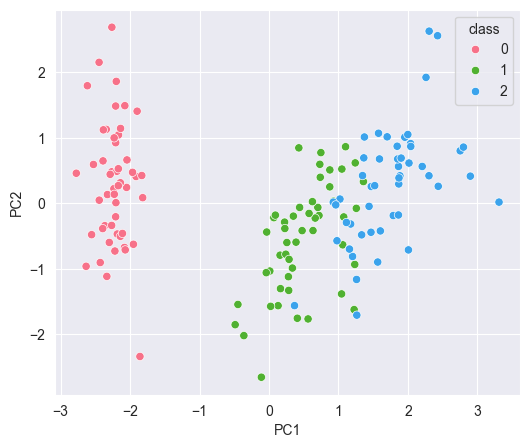

In [12]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
iris = load_iris()
X = iris.data
y = iris.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
draw(X, y)
plt.savefig("output.png", dpi=1000)

---
### calculate LDA

LDA: 2.01ms


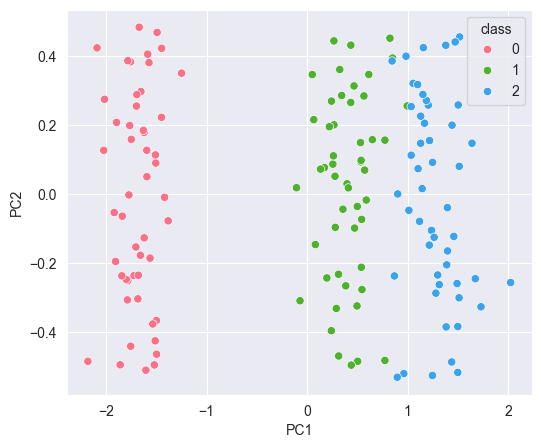

In [13]:
from lda import LDA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
with Timer("LDA"):
    lda.fit(X, y)
    reduced_X = lda.transform(X)
draw(reduced_X, y)
plt.savefig("output.png", dpi=1000)

---
### w/ LDA 

In [14]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler

def cal_metrics(clf, X=reduced_X):
    loo = LeaveOneOut()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Calculate accuracy
    acc_scores = cross_val_score(clf, X_scaled, y, cv=loo)
    acc = acc_scores.mean() * 100
    return acc, None

from sklearn.naive_bayes import GaussianNB as Classifier
with Timer("LeaveOneOut_GaussianNB"):
    acc, _ = cal_metrics(Classifier())
print(f"GaussianNB_acc:\t\t\t\t{acc:.3f}")

from sklearn.linear_model import LogisticRegression as Classifier
with Timer("LeaveOneOut_LogisticRegression"):
    acc, _ = cal_metrics(Classifier(max_iter=100))
print(f"LogisticRegression_acc:\t\t{acc:.3f}")

from sklearn.neighbors import KNeighborsClassifier as Classifier
with Timer("LeaveOneOut_KNeighborsClassifier"):
    acc, _ = cal_metrics(Classifier(n_neighbors=8))
print(f"KNeighborsClassifier_acc:\t{acc:.3f}")

LeaveOneOut_GaussianNB: 250.46ms
GaussianNB_acc:				98.667
LeaveOneOut_LogisticRegression: 512.34ms
LogisticRegression_acc:		98.000
LeaveOneOut_KNeighborsClassifier: 406.28ms
KNeighborsClassifier_acc:	96.667


---
### w/o LDA

In [15]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler

def cal_metrics(clf, X=X):
    loo = LeaveOneOut()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Calculate accuracy
    acc_scores = cross_val_score(clf, X_scaled, y, cv=loo)
    acc = acc_scores.mean() * 100
    return acc, None

from sklearn.naive_bayes import GaussianNB as Classifier
with Timer("LeaveOneOut_GaussianNB"):
    acc, _ = cal_metrics(Classifier())
print(f"GaussianNB_acc:\t\t\t\t{acc:.3f}")

from sklearn.linear_model import LogisticRegression as Classifier
with Timer("LeaveOneOut_LogisticRegression"):
    acc, _ = cal_metrics(Classifier(max_iter=100))
print(f"LogisticRegression_acc:\t\t{acc:.3f}")

from sklearn.neighbors import KNeighborsClassifier as Classifier
with Timer("LeaveOneOut_KNeighborsClassifier"):
    acc, _ = cal_metrics(Classifier(n_neighbors=8))
print(f"KNeighborsClassifier_acc:\t{acc:.3f}")

LeaveOneOut_GaussianNB: 256.05ms
GaussianNB_acc:				95.333
LeaveOneOut_LogisticRegression: 636.82ms
LogisticRegression_acc:		95.333
LeaveOneOut_KNeighborsClassifier: 448.83ms
KNeighborsClassifier_acc:	95.333


---
### drop 20% w/ LDA

In [16]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

def cal_metrics(clf, X=reduced_X):
    cv = ShuffleSplit(n_splits=1000, test_size=0.8)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    acc_scores = cross_val_score(clf, X_scaled, y, cv=cv)
    acc = acc_scores.mean() * 100
    return acc, acc_scores.std()

with Timer("Random20_GaussianNB"):
    acc, std = cal_metrics(GaussianNB())
print(f"GaussianNB_acc:\t\t\t\t{acc:.3f}")
print(f"GaussianNB_std:\t\t\t\t{std:.3f}")

with Timer("Random20_LogisticRegression"):
    acc, std = cal_metrics(LogisticRegression())
print(f"LogisticRegression_acc:\t\t{acc:.3f}")
print(f"LogisticRegression_std:\t\t{std:.3f}")

with Timer("Random20_KNeighborsClassifier"):
    acc, std = cal_metrics(KNeighborsClassifier(n_neighbors=5))
print(f"KNeighborsClassifier_acc:\t{acc:.3f}")
print(f"KNeighborsClassifier_std:\t{std:.3f}")

Random20_GaussianNB: 1641.56ms
GaussianNB_acc:				97.131
GaussianNB_std:				0.020
Random20_LogisticRegression: 3214.73ms
LogisticRegression_acc:		92.453
LogisticRegression_std:		0.080
Random20_KNeighborsClassifier: 7209.98ms
KNeighborsClassifier_acc:	97.484
KNeighborsClassifier_std:	0.017


---
### drop 20% w/o LDA

In [17]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

def cal_metrics(clf, X=X):
    cv = ShuffleSplit(n_splits=1000, test_size=0.8)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    acc_scores = cross_val_score(clf, X_scaled, y, cv=cv)
    acc = acc_scores.mean() * 100
    return acc, acc_scores.std()

with Timer("Random20_GaussianNB"):
    acc, std = cal_metrics(GaussianNB())
print(f"GaussianNB_acc:\t\t\t\t{acc:.3f}")
print(f"GaussianNB_std:\t\t\t\t{std:.3f}")

with Timer("Random20_LogisticRegression"):
    acc, std = cal_metrics(LogisticRegression())
print(f"LogisticRegression_acc:\t\t{acc:.3f}")
print(f"LogisticRegression_std:\t\t{std:.3f}")

with Timer("Random20_KNeighborsClassifier"):
    acc, std = cal_metrics(KNeighborsClassifier(n_neighbors=5))
print(f"KNeighborsClassifier_acc:\t{acc:.3f}")
print(f"KNeighborsClassifier_std:\t{std:.3f}")

Random20_GaussianNB: 1848.19ms
GaussianNB_acc:				93.918
GaussianNB_std:				0.029
Random20_LogisticRegression: 3649.78ms
LogisticRegression_acc:		91.008
LogisticRegression_std:		0.048
Random20_KNeighborsClassifier: 7512.83ms
KNeighborsClassifier_acc:	90.012
KNeighborsClassifier_std:	0.048
